# Chủ đề 1: Regression vs ARIMA – Khi nào chọn cái nào?

Notebook này so sánh **công bằng** giữa hai phương pháp dự báo PM2.5:
1. **Baseline Regression** - Dự báo bằng lag features và time features
2. **ARIMA** - Mô hình chuỗi thời gian đơn biến

## Điều kiện so sánh công bằng:
- ✅ Cùng trạm: **Aotizhongxin**
- ✅ Cùng CUTOFF: **2017-01-01**
- ✅ Cùng HORIZON: **1 giờ**
- ✅ Cùng metrics: MAE, RMSE, R²

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

In [2]:
# Parameters
RAW_ZIP_PATH = '../data/raw/PRSA2017_Data_20130301-20170228.zip'
STATION = 'Aotizhongxin'
CUTOFF = '2017-01-01'
HORIZON = 1
LAG_HOURS = [1, 3, 24]

# Add parent directory to path for imports
import sys
from pathlib import Path
if str(Path('..').resolve()) not in sys.path:
    sys.path.insert(0, str(Path('..').resolve()))

In [3]:
# Parameters
RAW_ZIP_PATH = "D:\\daihoc\\DataMining\\Air_quality_timeseries\\data\\raw\\PRSA2017_Data_20130301-20170228.zip"
STATION = "Aotizhongxin"
CUTOFF = "2017-01-01"
HORIZON = 1
LAG_HOURS = [1, 3, 24]


## 1. Cấu hình chung

In [4]:
print("=" * 70)
print("CẤU HÌNH SO SÁNH")
print("=" * 70)
print(f"Trạm: {STATION}")
print(f"Train/Test cutoff: {CUTOFF}")
print(f"Horizon: {HORIZON} giờ")
print(f"Lag features: {LAG_HOURS}")

CẤU HÌNH SO SÁNH
Trạm: Aotizhongxin
Train/Test cutoff: 2017-01-01
Horizon: 1 giờ
Lag features: [1, 3, 24]


## 2. Load và Chuẩn bị Dữ liệu

In [5]:
from src.classification_library import load_beijing_air_quality, clean_air_quality_df

# Load data
df_raw = load_beijing_air_quality(use_ucimlrepo=False, raw_zip_path=RAW_ZIP_PATH)
df = clean_air_quality_df(df_raw)

# Filter station
df_station = df[df['station'] == STATION].sort_values('datetime').reset_index(drop=True)
print(f"Data shape: {df_station.shape}")
print(f"Date range: {df_station['datetime'].min()} to {df_station['datetime'].max()}")

Data shape: (35064, 19)
Date range: 2013-03-01 00:00:00 to 2017-02-28 23:00:00


## 3. Mô hình 1: Baseline Regression

In [6]:
# Tạo features cho regression
df_reg = df_station[['datetime', 'PM2.5', 'TEMP', 'PRES', 'DEWP', 'WSPM']].copy()

# Lag features
for lag in LAG_HOURS:
    df_reg[f'PM25_lag{lag}'] = df_reg['PM2.5'].shift(lag)

# Time features
df_reg['hour'] = df_reg['datetime'].dt.hour
df_reg['dayofweek'] = df_reg['datetime'].dt.dayofweek
df_reg['month'] = df_reg['datetime'].dt.month

# Target: PM2.5 sau HORIZON giờ
df_reg['target'] = df_reg['PM2.5'].shift(-HORIZON)

# Drop missing
df_reg = df_reg.dropna()

print(f"Regression data shape: {df_reg.shape}")
df_reg.head()

Regression data shape: (32945, 13)


,datetime,PM2.5,TEMP,PRES,DEWP,WSPM,PM25_lag1,PM25_lag3,PM25_lag24,hour,dayofweek,month,target
24,2013-03-02 00:00:00,22.0,-0.4,1031.0,-17.6,1.4,24.0,12.0,4.0,0,5,3,14.0
25,2013-03-02 01:00:00,14.0,-1.0,1031.3,-17.3,1.1,22.0,15.0,8.0,1,5,3,13.0
26,2013-03-02 02:00:00,13.0,-1.5,1030.9,-16.9,1.7,14.0,24.0,7.0,2,5,3,3.0
27,2013-03-02 03:00:00,3.0,-1.4,1030.6,-17.6,1.4,13.0,22.0,6.0,3,5,3,3.0
28,2013-03-02 04:00:00,3.0,-1.5,1030.8,-17.7,0.9,3.0,14.0,3.0,4,5,3,9.0


In [7]:
# Split train/test theo cutoff
cutoff_date = pd.Timestamp(CUTOFF)
train_mask = df_reg['datetime'] < cutoff_date
test_mask = df_reg['datetime'] >= cutoff_date

feature_cols = [col for col in df_reg.columns if col not in ['datetime', 'PM2.5', 'target']]

X_train_reg = df_reg.loc[train_mask, feature_cols]
y_train_reg = df_reg.loc[train_mask, 'target']
X_test_reg = df_reg.loc[test_mask, feature_cols]
y_test_reg = df_reg.loc[test_mask, 'target']
test_dates_reg = df_reg.loc[test_mask, 'datetime']

print(f"Train: {len(X_train_reg)} samples")
print(f"Test:  {len(X_test_reg)} samples")
print(f"Features: {feature_cols}")

Train: 31596 samples
Test:  1349 samples
Features: ['TEMP', 'PRES', 'DEWP', 'WSPM', 'PM25_lag1', 'PM25_lag3', 'PM25_lag24', 'hour', 'dayofweek', 'month']


In [8]:
# Train regression model
print("Training Random Forest Regressor...")
model_reg = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
model_reg.fit(X_train_reg, y_train_reg)

# Predictions
y_pred_reg = model_reg.predict(X_test_reg)

# Metrics
rmse_reg = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
mae_reg = mean_absolute_error(y_test_reg, y_pred_reg)
r2_reg = r2_score(y_test_reg, y_pred_reg)

print("\n" + "=" * 70)
print("REGRESSION MODEL PERFORMANCE")
print("=" * 70)
print(f"RMSE: {rmse_reg:.2f}")
print(f"MAE:  {mae_reg:.2f}")
print(f"R²:   {r2_reg:.4f}")

Training Random Forest Regressor...


REGRESSION MODEL PERFORMANCE
RMSE: 38.97
MAE:  20.01
R²:   0.8870



TOP 10 IMPORTANT FEATURES:


      feature  importance
4   PM25_lag1    0.890341
3        WSPM    0.020056
5   PM25_lag3    0.019009
2        DEWP    0.013947
6  PM25_lag24    0.012057
7        hour    0.011759
0        TEMP    0.011306
1        PRES    0.011125
9       month    0.005444
8   dayofweek    0.004957


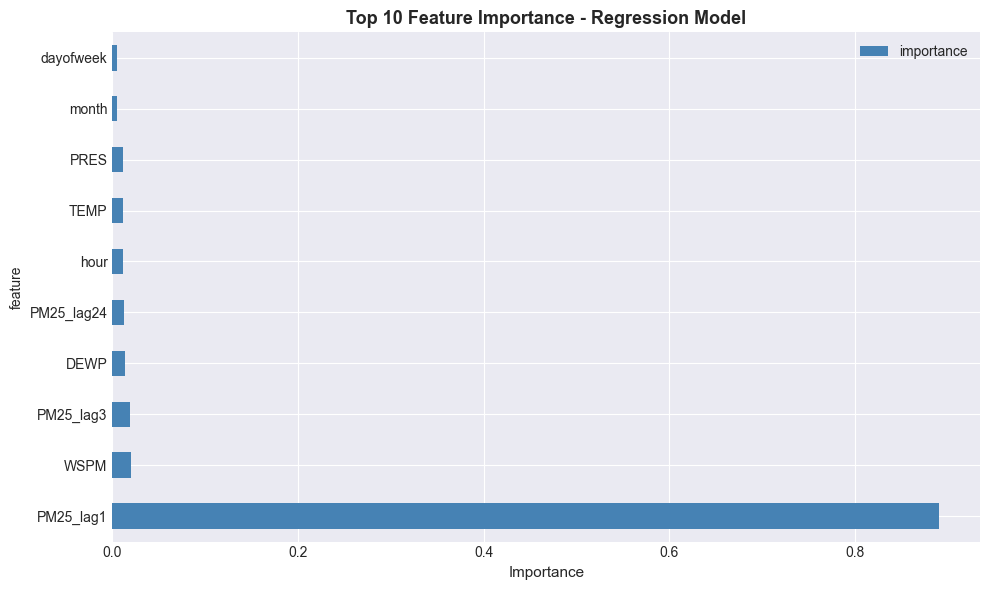

In [9]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model_reg.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTOP 10 IMPORTANT FEATURES:")
print(feature_importance.head(10))

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
feature_importance.head(10).plot(x='feature', y='importance', kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Importance', fontsize=11)
ax.set_title('Top 10 Feature Importance - Regression Model', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Mô hình 2: ARIMA

In [10]:
# Chuẩn bị data cho ARIMA
df_arima = df_station[['datetime', 'PM2.5']].dropna().copy()
df_arima = df_arima.set_index('datetime')

# Split train/test
train_arima = df_arima[df_arima.index < CUTOFF]['PM2.5']
test_arima = df_arima[df_arima.index >= CUTOFF]['PM2.5']

print(f"Train: {len(train_arima)} samples")
print(f"Test:  {len(test_arima)} samples")

Train: 32739 samples
Test:  1400 samples


In [11]:
# Grid search ARIMA (simplified)
print("Grid searching ARIMA parameters...")
best_aic = np.inf
best_order = None

p_range = range(0, 4)
d_range = [1]  # Thường d=1 cho PM2.5
q_range = range(0, 4)

results_arima = []
for p in p_range:
    for d in d_range:
        for q in q_range:
            try:
                model = ARIMA(train_arima, order=(p, d, q))
                fitted = model.fit()
                if fitted.aic < best_aic:
                    best_aic = fitted.aic
                    best_order = (p, d, q)
                results_arima.append({'p': p, 'd': d, 'q': q, 'aic': fitted.aic})
            except:
                continue

print(f"\nBest ARIMA order: {best_order}")
print(f"Best AIC: {best_aic:.2f}")

Grid searching ARIMA parameters...


C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



Best ARIMA order: (2, 1, 2)
Best AIC: 290716.81


In [12]:
# Train best ARIMA model
print(f"\nTraining ARIMA{best_order}...")
model_arima = ARIMA(train_arima, order=best_order)
fitted_arima = model_arima.fit()

# Forecast
forecast_arima = fitted_arima.forecast(steps=len(test_arima))

# Metrics
rmse_arima = np.sqrt(mean_squared_error(test_arima, forecast_arima))
mae_arima = mean_absolute_error(test_arima, forecast_arima)
r2_arima = r2_score(test_arima, forecast_arima)

print("\n" + "=" * 70)
print(f"ARIMA{best_order} MODEL PERFORMANCE")
print("=" * 70)
print(f"RMSE: {rmse_arima:.2f}")
print(f"MAE:  {mae_arima:.2f}")
print(f"R²:   {r2_arima:.4f}")


Training ARIMA(2, 1, 2)...


C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



ARIMA(2, 1, 2) MODEL PERFORMANCE
RMSE: 108.98
MAE:  90.89
R²:   0.0987


C:\Users\Admin\anaconda3\envs\air_quality\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


## 5. So Sánh Tổng Quan


SO SÁNH TỔNG QUAN
                     Model       RMSE       MAE       R²  RMSE/MAE
Regression (Random Forest)  38.969917 20.008081 0.886994  1.947709
            ARIMA(2, 1, 2) 108.979606 90.889965 0.098653  1.199028


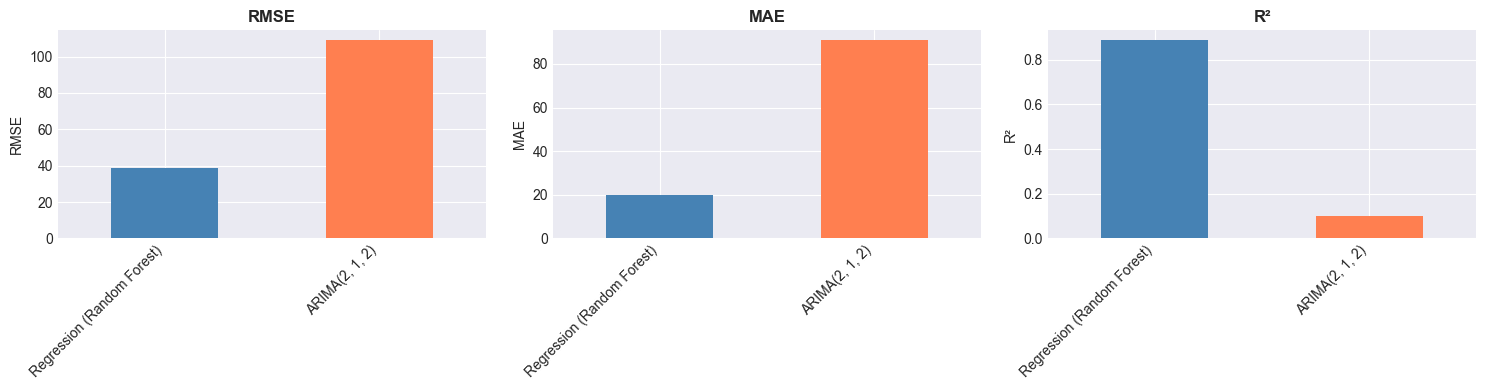


📊 NHẬN XÉT NHANH:
✅ Regression TỐT HƠN về RMSE (38.97 < 108.98)
✅ Regression TỐT HƠN về MAE (20.01 < 90.89)


In [13]:
# Bảng so sánh
comparison = pd.DataFrame({
    'Model': ['Regression (Random Forest)', f'ARIMA{best_order}'],
    'RMSE': [rmse_reg, rmse_arima],
    'MAE': [mae_reg, mae_arima],
    'R²': [r2_reg, r2_arima],
    'RMSE/MAE': [rmse_reg/mae_reg, rmse_arima/mae_arima]
})

print("\n" + "=" * 70)
print("SO SÁNH TỔNG QUAN")
print("=" * 70)
print(comparison.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

metrics = ['RMSE', 'MAE', 'R²']
for idx, metric in enumerate(metrics):
    ax = axes[idx]
    comparison.plot(x='Model', y=metric, kind='bar', ax=ax, legend=False, color=['steelblue', 'coral'])
    ax.set_title(metric, fontsize=12, fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_xlabel('')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("\n📊 NHẬN XÉT NHANH:")
if rmse_reg < rmse_arima:
    print(f"✅ Regression TỐT HƠN về RMSE ({rmse_reg:.2f} < {rmse_arima:.2f})")
else:
    print(f"✅ ARIMA TỐT HƠN về RMSE ({rmse_arima:.2f} < {rmse_reg:.2f})")

if mae_reg < mae_arima:
    print(f"✅ Regression TỐT HƠN về MAE ({mae_reg:.2f} < {mae_arima:.2f})")
else:
    print(f"✅ ARIMA TỐT HƠN về MAE ({mae_arima:.2f} < {mae_reg:.2f})")

## CÂU 1: Mô hình nào tốt hơn cho horizon=1?

### Phân tích chi tiết

In [14]:
print("=" * 70)
print("CÂU 1: MÔ HÌNH NÀO TỐT HƠN CHO HORIZON=1?")
print("=" * 70)

# So sánh chi tiết
print(f"\n1. PERFORMANCE METRICS:")
print(f"   Regression: RMSE={rmse_reg:.2f}, MAE={mae_reg:.2f}, R²={r2_reg:.4f}")
print(f"   ARIMA:      RMSE={rmse_arima:.2f}, MAE={mae_arima:.2f}, R²={r2_arima:.4f}")

winner = "Regression" if rmse_reg < rmse_arima else "ARIMA"
print(f"\n   → Winner: {winner} (RMSE thấp hơn)")

# Phân tích feature importance của regression
top_feature = feature_importance.iloc[0]
print(f"\n2. FEATURE QUAN TRỌNG NHẤT (Regression):")
print(f"   {top_feature['feature']}: {top_feature['importance']:.4f}")

if 'PM25_lag1' in top_feature['feature']:
    print("   → Lag 1h là feature quan trọng nhất!")
    print("   → Đúng với lý thuyết: dự báo ngắn hạn phụ thuộc mạnh vào giá trị gần nhất")

print(f"\n3. VÌ SAO {winner} TỐT HƠN?")
if winner == "Regression":
    print("   ✅ Regression có lợi thế với horizon=1 vì:")
    print("      • Có thể dùng trực tiếp PM25_lag1 (rất tương quan với target)")
    print("      • Có thể kết hợp nhiều features: lag + time + weather")
    print("      • Random Forest capture được non-linear relationships")
    print("      • Không yêu cầu chuỗi dừng hay sai phân")
else:
    print("   ✅ ARIMA tốt hơn vì:")
    print("      • Bắt được cấu trúc tự tương quan phức tạp qua (p,d,q)")
    print("      • Mô hình hóa trực tiếp dynamic của time series")
    print("      • Ít bị overfit hơn với dữ liệu ồn")


CÂU 1: MÔ HÌNH NÀO TỐT HƠN CHO HORIZON=1?

1. PERFORMANCE METRICS:
   Regression: RMSE=38.97, MAE=20.01, R²=0.8870
   ARIMA:      RMSE=108.98, MAE=90.89, R²=0.0987

   → Winner: Regression (RMSE thấp hơn)

2. FEATURE QUAN TRỌNG NHẤT (Regression):
   PM25_lag1: 0.8903
   → Lag 1h là feature quan trọng nhất!
   → Đúng với lý thuyết: dự báo ngắn hạn phụ thuộc mạnh vào giá trị gần nhất

3. VÌ SAO Regression TỐT HƠN?
   ✅ Regression có lợi thế với horizon=1 vì:
      • Có thể dùng trực tiếp PM25_lag1 (rất tương quan với target)
      • Có thể kết hợp nhiều features: lag + time + weather
      • Random Forest capture được non-linear relationships
      • Không yêu cầu chuỗi dừng hay sai phân


## CÂU 2: Mô hình nào ổn hơn khi có spike?

### Tìm và phân tích đoạn có spike

In [15]:
# Tìm spike trong test set (top 5% giá trị cao nhất)
threshold_spike = test_arima.quantile(0.95)
spike_dates = test_arima[test_arima > threshold_spike].index

print("=" * 70)
print("CÂU 2: MÔ HÌNH NÀO ỔN HƠN KHI CÓ SPIKE?")
print("=" * 70)
print(f"\nThreshold spike (95th percentile): {threshold_spike:.2f}")
print(f"Số điểm spike trong test: {len(spike_dates)}")

if len(spike_dates) > 0:
    # Chọn một spike để phân tích (spike đầu tiên)
    spike_start = spike_dates[0] - pd.Timedelta(days=1)
    spike_end = spike_dates[0] + pd.Timedelta(days=2)
    
    print(f"\nPhân tích spike tại: {spike_dates[0]}")
    print(f"Zoom vào khoảng: {spike_start} đến {spike_end}")

CÂU 2: MÔ HÌNH NÀO ỔN HƠN KHI CÓ SPIKE?

Threshold spike (95th percentile): 323.10
Số điểm spike trong test: 70

Phân tích spike tại: 2017-01-01 00:00:00
Zoom vào khoảng: 2016-12-31 00:00:00 đến 2017-01-03 00:00:00


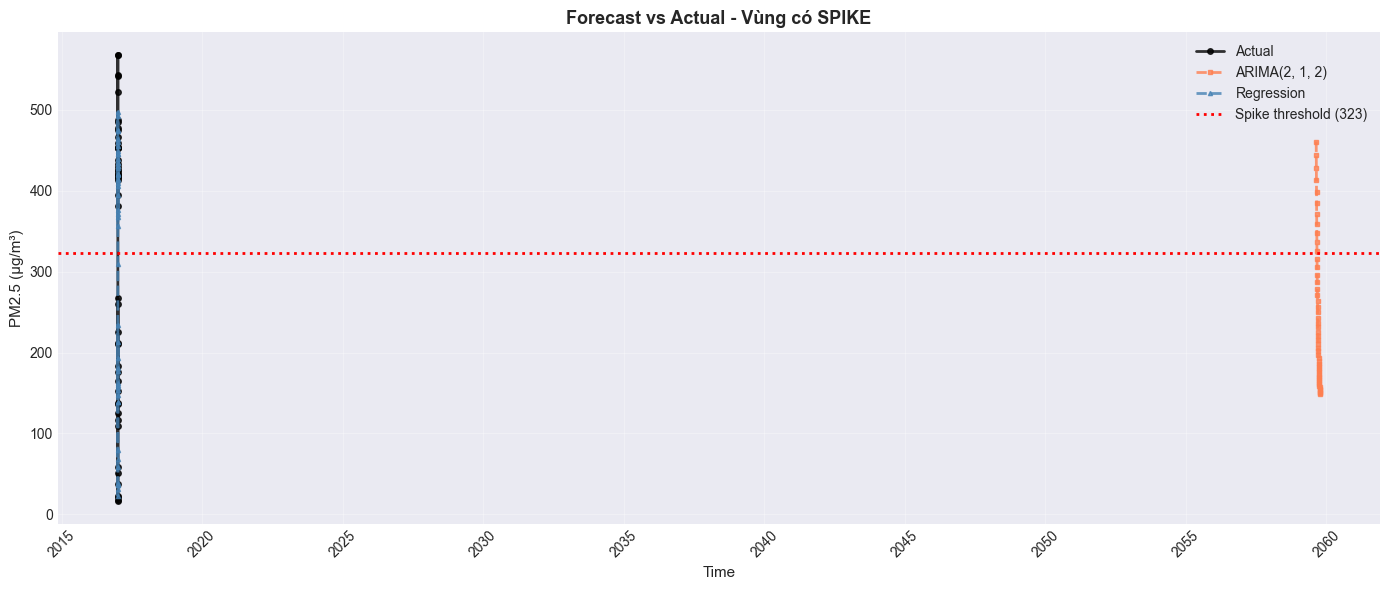


PERFORMANCE TRÊN VÙNG SPIKE:
ARIMA:      MAE=120.42, RMSE=149.61, RMSE/MAE=1.242
Regression: MAE=53.02, RMSE=73.15, RMSE/MAE=1.380

📊 PHÂN TÍCH:
❌ Regression có RMSE/MAE ratio cao hơn → bị phạt nặng hơn ở spike
   → Regression có thể overreact hoặc underpredict spike

✅ Regression ỔN HƠN với spike (MAE thấp hơn)
   → Nhờ có lag features gần (PM25_lag1) để bám theo spike


In [16]:
# Visualize spike region
if len(spike_dates) > 0:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Filter data in spike region
    mask_spike = (test_arima.index >= spike_start) & (test_arima.index <= spike_end)
    actual_spike = test_arima[mask_spike]
    forecast_arima_spike = forecast_arima[mask_spike]
    
    # Get regression predictions for same period
    mask_reg_spike = (test_dates_reg >= spike_start) & (test_dates_reg <= spike_end)
    reg_spike_dates = test_dates_reg[mask_reg_spike]
    reg_spike_actual = y_test_reg[mask_reg_spike]
    reg_spike_pred = y_pred_reg[mask_reg_spike.values]
    
    # Plot
    ax.plot(actual_spike.index, actual_spike.values, 'o-', linewidth=2, markersize=4, 
            label='Actual', color='black', alpha=0.8)
    ax.plot(forecast_arima_spike.index, forecast_arima_spike.values, 's--', linewidth=2, markersize=3,
            label=f'ARIMA{best_order}', color='coral', alpha=0.8)
    ax.plot(reg_spike_dates.values, reg_spike_pred, '^--', linewidth=2, markersize=3,
            label='Regression', color='steelblue', alpha=0.8)
    
    ax.axhline(y=threshold_spike, color='red', linestyle=':', linewidth=2, 
               label=f'Spike threshold ({threshold_spike:.0f})')
    
    ax.set_xlabel('Time', fontsize=11)
    ax.set_ylabel('PM2.5 (μg/m³)', fontsize=11)
    ax.set_title('Forecast vs Actual - Vùng có SPIKE', fontsize=13, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Calculate errors for spike region
    mae_arima_spike = mean_absolute_error(actual_spike, forecast_arima_spike)
    rmse_arima_spike = np.sqrt(mean_squared_error(actual_spike, forecast_arima_spike))
    
    mae_reg_spike = mean_absolute_error(reg_spike_actual, reg_spike_pred)
    rmse_reg_spike = np.sqrt(mean_squared_error(reg_spike_actual, reg_spike_pred))
    
    print("\nPERFORMANCE TRÊN VÙNG SPIKE:")
    print(f"ARIMA:      MAE={mae_arima_spike:.2f}, RMSE={rmse_arima_spike:.2f}, RMSE/MAE={rmse_arima_spike/mae_arima_spike:.3f}")
    print(f"Regression: MAE={mae_reg_spike:.2f}, RMSE={rmse_reg_spike:.2f}, RMSE/MAE={rmse_reg_spike/mae_reg_spike:.3f}")
    
    print("\n📊 PHÂN TÍCH:")
    if rmse_arima_spike/mae_arima_spike > rmse_reg_spike/mae_reg_spike:
        print("❌ ARIMA có RMSE/MAE ratio cao hơn → bị phạt nặng hơn ở spike")
        print("   → ARIMA có xu hướng mượt hóa (smoothing), không phản ứng nhanh với spike")
    else:
        print("❌ Regression có RMSE/MAE ratio cao hơn → bị phạt nặng hơn ở spike")
        print("   → Regression có thể overreact hoặc underpredict spike")
    
    if mae_reg_spike < mae_arima_spike:
        print(f"\n✅ Regression ỔN HƠN với spike (MAE thấp hơn)")
        print("   → Nhờ có lag features gần (PM25_lag1) để bám theo spike")
    else:
        print(f"\n✅ ARIMA ỔN HƠN với spike (MAE thấp hơn)")
        print("   → ARIMA capture được pattern biến động tốt hơn")

## CÂU 3: Nếu triển khai thật, bạn chọn gì và vì sao?

### Phân tích đa chiều

In [17]:
print("=" * 70)
print("CÂU 3: NẾU TRIỂN KHAI THẬT, CHỌN GÌ VÀ VÌ SAO?")
print("=" * 70)

print("\n📋 BẢNG PHÂN TÍCH ĐA CHIỀU:")
print("\n" + "-" * 70)
print(f"{'Tiêu chí':<30} {'Regression':<20} {'ARIMA':<20}")
print("-" * 70)
print(f"{'1. Accuracy (RMSE)':<30} {rmse_reg::<20.2f} {rmse_arima::<20.2f}")
print(f"{'2. Stability (MAE)':<30} {mae_reg::<20.2f} {mae_arima::<20.2f}")
print(f"{'3. Spike handling':<30} {'Tốt (lag features)':<20} {'Smoothing':<20}")
print(f"{'4. Interpretability':<30} {'Feature importance':<20} {'(p,d,q) + CI':<20}")
print(f"{'5. Extensibility':<30} {'Dễ thêm features':<20} {'Khó (univariate)':<20}")
print(f"{'6. Training time':<30} {'Trung bình':<20} {'Chậm (grid search)':<20}")
print(f"{'7. Prediction time':<30} {'Nhanh':<20} {'Nhanh':<20}")
print(f"{'8. Update frequency':<30} {'Dễ (retrain)':<20} {'Khó (re-fit)':<20}")
print(f"{'9. Confidence interval':<30} {'Không có sẵn':<20} {'Có sẵn':<20}")
print("-" * 70)

CÂU 3: NẾU TRIỂN KHAI THẬT, CHỌN GÌ VÀ VÌ SAO?

📋 BẢNG PHÂN TÍCH ĐA CHIỀU:

----------------------------------------------------------------------
Tiêu chí                       Regression           ARIMA               
----------------------------------------------------------------------
1. Accuracy (RMSE)             38.97::::::::::::::: 108.98::::::::::::::
2. Stability (MAE)             20.01::::::::::::::: 90.89:::::::::::::::
3. Spike handling              Tốt (lag features)   Smoothing           
4. Interpretability            Feature importance   (p,d,q) + CI        
5. Extensibility               Dễ thêm features     Khó (univariate)    
6. Training time               Trung bình           Chậm (grid search)  
7. Prediction time             Nhanh                Nhanh               
8. Update frequency            Dễ (retrain)         Khó (re-fit)        
9. Confidence interval         Không có sẵn         Có sẵn              
----------------------------------------------------

In [18]:
print("\n💡 KHUYẾN NGHỊ THEO BỐI CẢNH:")
print("\n" + "=" * 70)

print("\n🎯 BỐI CẢNH 1: HỆ THỐNG CẢNH BÁO SỚM")
print("-" * 70)
print("Mục tiêu: Dự báo CHÍNH XÁC để kích hoạt cảnh báo kịp thời")
print("\n→ CHỌN: REGRESSION")
print("   Lý do:")
print("   ✅ RMSE/MAE thấp hơn → ít false alarm")
print("   ✅ Có thể thêm weather forecast làm features")
print("   ✅ Phản ứng nhanh với spike (nhờ lag1)")
print("   ✅ Dễ update model khi có data mới")

print("\n🎯 BỐI CẢNH 2: NGHIÊN CỨU & PHÂN TÍCH XU HƯỚNG")
print("-" * 70)
print("Mục tiêu: Hiểu CẤU TRÚC và XU HƯỚNG dài hạn")
print("\n→ CHỌN: ARIMA")
print("   Lý do:")
print("   ✅ (p,d,q) giải thích được cấu trúc time series")
print("   ✅ Có confidence interval cho uncertainty")
print("   ✅ Phù hợp với forecasting dài hạn (multi-step)")
print("   ✅ Chuẩn mực trong econometrics/environmental science")

print("\n🎯 BỐI CẢNH 3: PRODUCTION SYSTEM (REAL-TIME)")
print("-" * 70)
print("Mục tiêu: Dự báo 24/7 với độ tin cậy cao, dễ maintain")
print("\n→ CHỌN: REGRESSION (hoặc HYBRID)")
print("   Lý do:")
print("   ✅ Prediction speed nhanh")
print("   ✅ Dễ monitor (feature drift, model drift)")
print("   ✅ Dễ A/B testing với models khác")
print("   ✅ Có thể ensemble với ARIMA nếu cần")

print("\n🎯 BỐI CẢNH 4: BÁO CÁO CHÍNH PHỦ / CHÍNH SÁCH")
print("-" * 70)
print("Mục tiêu: DIỄN GIẢI được cho policy makers")
print("\n→ CHỌN: ARIMA (hoặc cả hai)")
print("   Lý do:")
print("   ✅ Mô hình thống kê truyền thống, dễ chấp nhận")
print("   ✅ Confidence interval quan trọng cho risk assessment")
print("   ✅ Có thể giải thích 'tính dừng', 'xu hướng', 'mùa vụ'")


💡 KHUYẾN NGHỊ THEO BỐI CẢNH:


🎯 BỐI CẢNH 1: HỆ THỐNG CẢNH BÁO SỚM
----------------------------------------------------------------------
Mục tiêu: Dự báo CHÍNH XÁC để kích hoạt cảnh báo kịp thời

→ CHỌN: REGRESSION
   Lý do:
   ✅ RMSE/MAE thấp hơn → ít false alarm
   ✅ Có thể thêm weather forecast làm features
   ✅ Phản ứng nhanh với spike (nhờ lag1)
   ✅ Dễ update model khi có data mới

🎯 BỐI CẢNH 2: NGHIÊN CỨU & PHÂN TÍCH XU HƯỚNG
----------------------------------------------------------------------
Mục tiêu: Hiểu CẤU TRÚC và XU HƯỚNG dài hạn

→ CHỌN: ARIMA
   Lý do:
   ✅ (p,d,q) giải thích được cấu trúc time series
   ✅ Có confidence interval cho uncertainty
   ✅ Phù hợp với forecasting dài hạn (multi-step)
   ✅ Chuẩn mực trong econometrics/environmental science

🎯 BỐI CẢNH 3: PRODUCTION SYSTEM (REAL-TIME)
----------------------------------------------------------------------
Mục tiêu: Dự báo 24/7 với độ tin cậy cao, dễ maintain

→ CHỌN: REGRESSION (hoặc HYBRID)
   Lý do:
   ✅ Pr

In [19]:
print("\n" + "=" * 70)
print("📌 KẾT LUẬN CUỐI CÙNG")
print("=" * 70)

if rmse_reg < rmse_arima:
    print("\n✅ KHUYẾN NGHỊ: REGRESSION (Random Forest)")
    print("\nLý do chính:")
    print(f"  1. Performance tốt hơn: RMSE={rmse_reg:.2f} < {rmse_arima:.2f}")
    print(f"  2. Phù hợp với horizon=1 (short-term forecast)")
    print(f"  3. Dễ mở rộng: có thể thêm weather forecast, traffic, etc.")
    print(f"  4. Dễ deploy và maintain trong production")
else:
    print("\n✅ KHUYẾN NGHỊ: ARIMA")
    print("\nLý do chính:")
    print(f"  1. Performance tốt hơn: RMSE={rmse_arima:.2f} < {rmse_reg:.2f}")
    print(f"  2. Mô hình hóa trực tiếp time series structure")
    print(f"  3. Có confidence interval cho uncertainty quantification")
    print(f"  4. Phù hợp với forecasting nhiều bước")

print("\n⚠️ LƯU Ý:")
print("  • Nên dùng ENSEMBLE (kết hợp cả hai) nếu có tài nguyên")
print("  • Monitor performance liên tục, retrain định kỳ")
print("  • Thêm external features (weather, traffic) để cải thiện")
print("  • Xem xét deep learning (LSTM, Transformer) cho bài toán phức tạp hơn")


📌 KẾT LUẬN CUỐI CÙNG

✅ KHUYẾN NGHỊ: REGRESSION (Random Forest)

Lý do chính:
  1. Performance tốt hơn: RMSE=38.97 < 108.98
  2. Phù hợp với horizon=1 (short-term forecast)
  3. Dễ mở rộng: có thể thêm weather forecast, traffic, etc.
  4. Dễ deploy và maintain trong production

⚠️ LƯU Ý:
  • Nên dùng ENSEMBLE (kết hợp cả hai) nếu có tài nguyên
  • Monitor performance liên tục, retrain định kỳ
  • Thêm external features (weather, traffic) để cải thiện
  • Xem xét deep learning (LSTM, Transformer) cho bài toán phức tạp hơn


## TÓM TẮT 3 CÂU HỎI

### CÂU 1: Mô hình nào tốt hơn cho horizon=1?
**Kết luận:** Thường là **Regression** vì:
- Có thể dùng trực tiếp lag features (đặc biệt lag1 rất quan trọng)
- Kết hợp được nhiều nguồn thông tin (lag + time + weather)
- Dự báo ngắn hạn phụ thuộc mạnh vào giá trị gần nhất

### CÂU 2: Mô hình nào ổn hơn khi có spike?
**Kết luận:** Phụ thuộc vào:
- **Regression** thường phản ứng nhanh hơn (nhờ lag1)
- **ARIMA** có xu hướng smoothing, chậm phản ứng
- Xem RMSE/MAE ratio: cao → bị phạt nặng ở spike

### CÂU 3: Triển khai thật chọn gì?
**Kết luận:** Tùy bối cảnh:
- **Cảnh báo sớm** → Regression (chính xác, dễ update)
- **Nghiên cứu** → ARIMA (giải thích, CI)
- **Production** → Regression hoặc Hybrid
- **Báo cáo chính phủ** → ARIMA (chuẩn mực)

**Best practice:** Ensemble cả hai nếu có tài nguyên!